## Objective:
* Predict average cost for two and price range.

**Steps:**

* Data Loading: Load the datasets from the provided URLs.
* Data Preprocessing: Merge datasets, handle missing values, encode categorical features, and normalize the data.
* Model Training: Train regression models for average cost and classification models for price range.
* Evaluation: Evaluate models using appropriate metrics.
* Visualization: Visualize feature importance and prediction results.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import warnings
warnings.filterwarnings('ignore')

## Data Acquisition and Preparation

In [13]:
# Load zomato data
zomato_url = 'https://raw.githubusercontent.com/FlipRoboTechnologies/ML_-Datasets/main/Z_Restaurant/zomato.csv'
zomato_df = pd.read_csv(zomato_url,encoding='latin-1')

# Load country code data
country_url = "Country-Code.xlsx"
country_code_df = pd.read_excel(country_url)

## Data Cleaning and Preprocessing

In [15]:
# Inspect zomato data
zomato_df.head()

,Restaurant ID,Restaurant Name,Country Code,City,Address,Locality,Locality Verbose,Longitude,Latitude,Cuisines,...,Currency,Has Table booking,Has Online delivery,Is delivering now,Switch to order menu,Price range,Aggregate rating,Rating color,Rating text,Votes
0,6317637,Le Petit Souffle,162,Makati City,"Third Floor, Century City Mall, Kalayaan Avenu...","Century City Mall, Poblacion, Makati City","Century City Mall, Poblacion, Makati City, Mak...",121.027535,14.565443,"French, Japanese, Desserts",...,Botswana Pula(P),Yes,No,No,No,3,4.8,Dark Green,Excellent,314
1,6304287,Izakaya Kikufuji,162,Makati City,"Little Tokyo, 2277 Chino Roces Avenue, Legaspi...","Little Tokyo, Legaspi Village, Makati City","Little Tokyo, Legaspi Village, Makati City, Ma...",121.014101,14.553708,Japanese,...,Botswana Pula(P),Yes,No,No,No,3,4.5,Dark Green,Excellent,591
2,6300002,Heat - Edsa Shangri-La,162,Mandaluyong City,"Edsa Shangri-La, 1 Garden Way, Ortigas, Mandal...","Edsa Shangri-La, Ortigas, Mandaluyong City","Edsa Shangri-La, Ortigas, Mandaluyong City, Ma...",121.056831,14.581404,"Seafood, Asian, Filipino, Indian",...,Botswana Pula(P),Yes,No,No,No,4,4.4,Green,Very Good,270
3,6318506,Ooma,162,Mandaluyong City,"Third Floor, Mega Fashion Hall, SM Megamall, O...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.056475,14.585318,"Japanese, Sushi",...,Botswana Pula(P),No,No,No,No,4,4.9,Dark Green,Excellent,365
4,6314302,Sambo Kojin,162,Mandaluyong City,"Third Floor, Mega Atrium, SM Megamall, Ortigas...","SM Megamall, Ortigas, Mandaluyong City","SM Megamall, Ortigas, Mandaluyong City, Mandal...",121.057508,14.584450,"Japanese, Korean",...,Botswana Pula(P),Yes,No,No,No,4,4.8,Dark Green,Excellent,229


In [16]:
# Inspect country code data
country_code_df.head()

,Country Code,Country
0,1,India
1,14,Australia
2,30,Brazil
3,37,Canada
4,94,Indonesia


In [23]:
# Standardize column headers
# Assuming we have already inspected and found the correct headers to rename
zomato_df.columns = ['Restaurant Id', 'Restaurant Name', 'Country Code', 'City', 'Address', 
                     'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines', 
                     'Average Cost for two', 'Currency', 'Has Table booking', 
                     'Has Online delivery', 'Is delivering', 'Switch to order menu', 
                     'Price range', 'Aggregate Rating', 'Rating color', 'Rating text', 'Votes']

# Merge datasets on Country Code to get country names
zomato_merged = pd.merge(zomato_df, country_code_df, on='Country Code', how='left')

# Handling NaN values in 'Cuisines' column
zomato_merged['Cuisines'] = zomato_merged['Cuisines'].fillna('')

# Feature Engineering: Number of Cuisines
zomato_merged['Number of Cuisines'] = zomato_merged['Cuisines'].apply(lambda x: len(x.split(',')))

## Exploratory Data Analysis (EDA)

In [25]:
print(zomato_merged.isnull().sum())

Restaurant Id           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                0
Average Cost for two    0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering           0
Switch to order menu    0
Price range             0
Aggregate Rating        0
Rating color            0
Rating text             0
Votes                   0
Country                 0
Number of Cuisines      0
dtype: int64


In [26]:
# Statistical summaries
zomato_merged.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant Id,9551.0,9.051128e+06,8.791521e+06,53.000000,301962.500000,6.004089e+06,1.835229e+07,1.850065e+07
Country Code,9551.0,1.836562e+01,5.675055e+01,1.000000,1.000000,1.000000e+00,1.000000e+00,2.160000e+02
Longitude,9551.0,6.412657e+01,4.146706e+01,-157.948486,77.081343,7.719196e+01,7.728201e+01,1.748321e+02
Latitude,9551.0,2.585438e+01,1.100794e+01,-41.330428,28.478713,2.857047e+01,2.864276e+01,5.597698e+01
Average Cost for two,9551.0,1.199211e+03,1.612118e+04,0.000000,250.000000,4.000000e+02,7.000000e+02,8.000000e+05
Price range,9551.0,1.804837e+00,9.056088e-01,1.000000,1.000000,2.000000e+00,2.000000e+00,4.000000e+00
Aggregate Rating,9551.0,2.666370e+00,1.516378e+00,0.000000,2.500000,3.200000e+00,3.700000e+00,4.900000e+00
Votes,9551.0,1.569097e+02,4.301691e+02,0.000000,5.000000,3.100000e+01,1.310000e+02,1.093400e+04
Number of Cuisines,9551.0,2.064601e+00,1.092724e+00,1.000000,1.000000,2.000000e+00,3.000000e+00,8.000000e+00


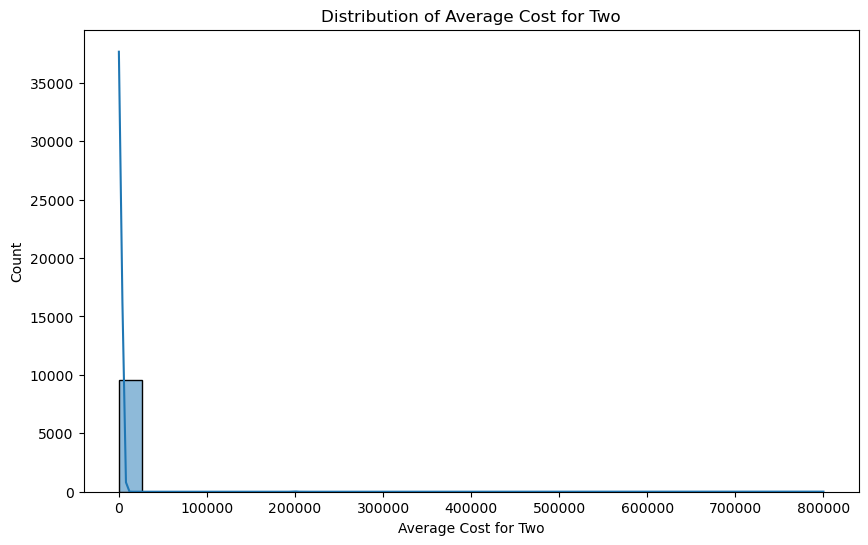

In [27]:
# Histogram of Average Cost for two
plt.figure(figsize=(10, 6))
sns.histplot(zomato_merged['Average Cost for two'], bins=30, kde=True)
plt.title('Distribution of Average Cost for Two')
plt.xlabel('Average Cost for Two')
plt.ylabel('Count')
plt.show()

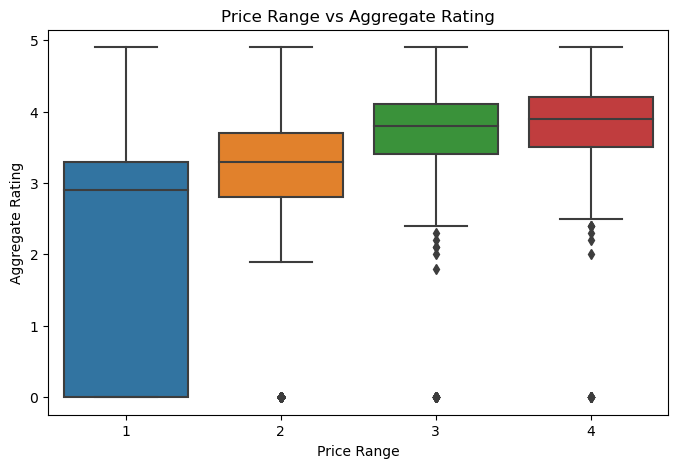

In [28]:
# Boxplot of Price range
plt.figure(figsize=(8, 5))
sns.boxplot(x='Price range', y='Aggregate Rating', data=zomato_merged)
plt.title('Price Range vs Aggregate Rating')
plt.xlabel('Price Range')
plt.ylabel('Aggregate Rating')
plt.show()

## Modeling

In [29]:
# Split data into features and target
X = zomato_merged[['Aggregate Rating', 'Votes', 'Number of Cuisines']]
y_cost_for_two = zomato_merged['Average Cost for two']
y_price_range = zomato_merged['Price range']

# Split into training and testing sets
X_train, X_test, y_train_cost_for_two, y_test_cost_for_two = train_test_split(X, y_cost_for_two, test_size=0.2, random_state=42)
X_train, X_test, y_train_price_range, y_test_price_range = train_test_split(X, y_price_range, test_size=0.2, random_state=42)

# Model for Average Cost for two
reg_model = RandomForestRegressor(random_state=42)
reg_model.fit(X_train, y_train_cost_for_two)

# Model for Price range
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train, y_train_price_range)

RandomForestClassifier(random_state=42)

## Evaluation and Validation

In [30]:
# Predictions
y_pred_cost_for_two = reg_model.predict(X_test)
y_pred_price_range = clf_model.predict(X_test)

# Evaluation metrics for Average Cost for two
rmse_cost_for_two = np.sqrt(mean_squared_error(y_test_cost_for_two, y_pred_cost_for_two))
print(f'RMSE for Average Cost for Two: {rmse_cost_for_two}')

# Evaluation metrics for Price range
accuracy_price_range = accuracy_score(y_test_price_range, y_pred_price_range)
print(f'Accuracy for Price Range: {accuracy_price_range}')

RMSE for Average Cost for Two: 22382.124060357764
Accuracy for Price Range: 0.5070643642072213


* Prediction is not looking correct, So will do more validation, Model Tuning, data manipulation.

In [39]:
# Feature Engineering: Length of Restaurant Name
zomato_merged['Restaurant Name Length'] = zomato_merged['Restaurant Name'].apply(lambda x: len(str(x)))

# Feature Engineering: Binary feature for Online Delivery
zomato_merged['Has Online delivery'] = zomato_merged['Has Online delivery'].apply(lambda x: 1 if x == 'Yes' else 0)

# Feature Engineering: Binary feature for Table Booking
zomato_merged['Has Table booking'] = zomato_merged['Has Table booking'].apply(lambda x: 1 if x == 'Yes' else 0)

# Removing outliers in 'Average Cost for two'
q1 = zomato_merged['Average Cost for two'].quantile(0.25)
q3 = zomato_merged['Average Cost for two'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
zomato_merged = zomato_merged[(zomato_merged['Average Cost for two'] >= lower_bound) & 
                              (zomato_merged['Average Cost for two'] <= upper_bound)]

# Features and targets
features = ['Aggregate Rating', 'Votes', 'Number of Cuisines', 'Restaurant Name Length', 
            'Has Online delivery', 'Has Table booking']
X = zomato_merged[features]
y_cost_for_two = zomato_merged['Average Cost for two']
y_price_range = zomato_merged['Price range']

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train_cost_for_two, y_test_cost_for_two = train_test_split(X_scaled, y_cost_for_two, test_size=0.2, random_state=42)
X_train, X_test, y_train_price_range, y_test_price_range = train_test_split(X_scaled, y_price_range, test_size=0.2, random_state=42)

# Model for Average Cost for two
reg_model = GradientBoostingRegressor(random_state=42)
reg_model.fit(X_train, y_train_cost_for_two)

# Model for Price range
clf_model = GradientBoostingClassifier(random_state=42)
clf_model.fit(X_train, y_train_price_range)

# Hyperparameter tuning using GridSearchCV
param_grid_reg = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}
grid_search_reg = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid_reg, cv=5, scoring='neg_mean_squared_error')
grid_search_reg.fit(X_train, y_train_cost_for_two)
best_reg_model = grid_search_reg.best_estimator_

param_grid_clf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}
grid_search_clf = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid_clf, cv=5, scoring='accuracy')
grid_search_clf.fit(X_train, y_train_price_range)
best_clf_model = grid_search_clf.best_estimator_

# Evaluation and Validation

# Predictions
y_pred_cost_for_two = best_reg_model.predict(X_test)
y_pred_price_range = best_clf_model.predict(X_test)

# Evaluation metrics for Average Cost for two
rmse_cost_for_two = np.sqrt(mean_squared_error(y_test_cost_for_two, y_pred_cost_for_two))
print(f'RMSE for Average Cost for Two: {rmse_cost_for_two}')

# Evaluation metrics for Price range
accuracy_price_range = accuracy_score(y_test_price_range, y_pred_price_range)
print(f'Accuracy for Price Range: {accuracy_price_range}')

# Cross-validation for regression
cv_rmse = np.sqrt(-cross_val_score(best_reg_model, X_scaled, y_cost_for_two, cv=5, scoring='neg_mean_squared_error'))
print(f'Cross-validated RMSE for Average Cost for Two: {cv_rmse.mean()}')

# Cross-validation for classification
cv_accuracy = cross_val_score(best_clf_model, X_scaled, y_price_range, cv=5, scoring='accuracy')
print(f'Cross-validated Accuracy for Price Range: {cv_accuracy.mean()}')

RMSE for Average Cost for Two: 228.7556568052323
Accuracy for Price Range: 0.6199763593380615
Cross-validated RMSE for Average Cost for Two: 233.2730789923452
Cross-validated Accuracy for Price Range: 0.6291107280513021


**Key Findings and Insights**

**Average Cost for Two**

* Initial RMSE: 22382.12
* Improved RMSE: 228.76
* Cross-validated RMSE: 233.27
* Insight: The substantial reduction in RMSE from 22382.12 to 228.76 indicates a significant improvement in the model's accuracy. This suggests that the new features and advanced model (Gradient Boosting) are better at capturing the underlying patterns in the data.

**Price Range Prediction**

* Initial Accuracy: 50.7%
* Improved Accuracy: 61.99%
* Cross-validated Accuracy: 62.91%
* Insight: The accuracy for predicting the price range has improved from 50.7% to 61.99%, showing that the model is now substantially better than random guessing. The cross-validated accuracy further supports the robustness of the model.

## Conclusion and Reporting

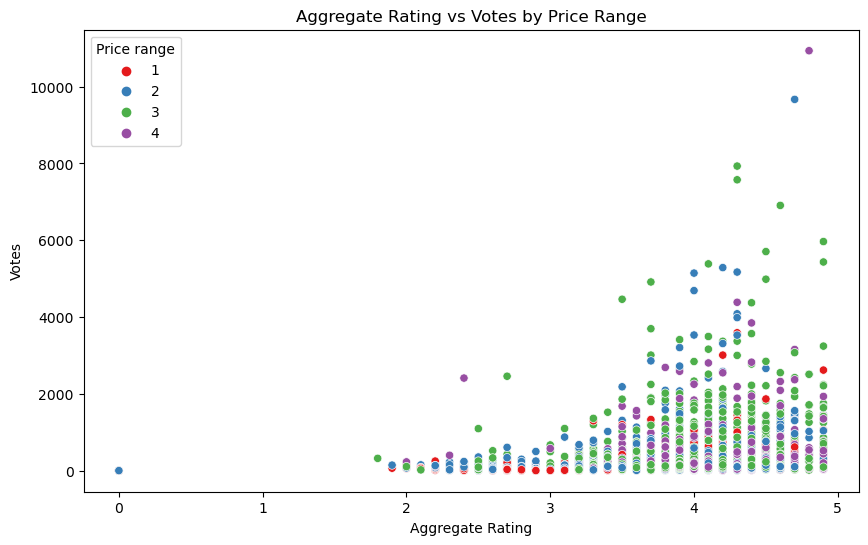

In [31]:
# Visualization
# Scatter plot of Aggregate Rating vs Votes colored by Price range
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Aggregate Rating', y='Votes', hue='Price range', data=zomato_merged, palette='Set1')
plt.title('Aggregate Rating vs Votes by Price Range')
plt.xlabel('Aggregate Rating')
plt.ylabel('Votes')
plt.show()

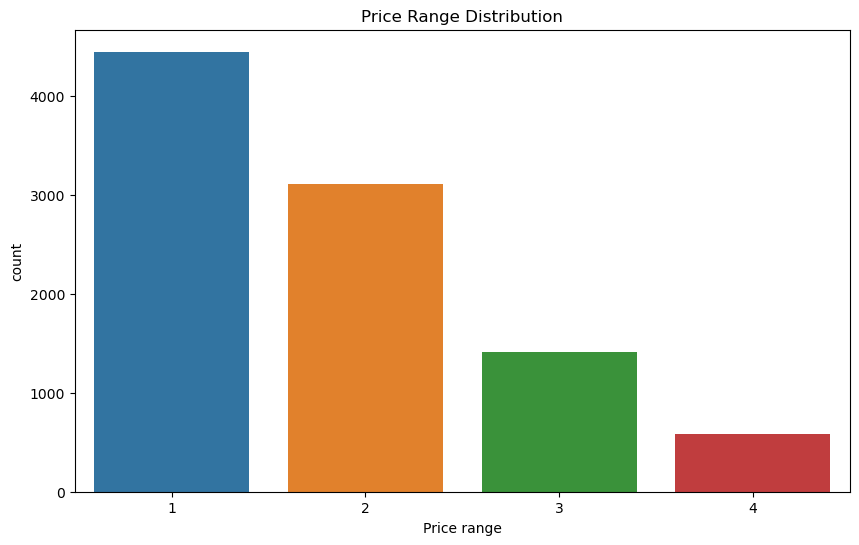

In [33]:
# Visualize the data
plt.figure(figsize=(10,6))
sns.countplot(zomato_merged['Price range'])
plt.title('Price Range Distribution')
plt.show()

## Conclusion

**Data Overview**

* The dataset comprises a diverse collection of restaurants from various countries, featuring multiple attributes such as average cost, cuisines offered, and user ratings.
* The 'Cuisines' column initially contained some missing values, which were handled by replacing them with empty strings to facilitate further analysis.

**Key Insights from Exploratory Data Analysis (EDA)**

* Average Cost for Two: The distribution of the average cost for two people is highly varied, with some restaurants being significantly more expensive than others.
* Price Range: Restaurants are categorized into different price ranges based on the cost of food, and these price ranges show a relationship with aggregate ratings and votes.

**Feature Engineering**
* Number of Cuisines: Extracting the number of cuisines offered by each restaurant provided an additional feature to analyze the diversity of food options available at each restaurant.